In [1]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import networkx as nx

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from nmp.node import Node
from nmp.edge import Edge
from nmp.message_passer import MessagePasser
from nmp.state_updater import StateUpdater
from nmp.nmp_tools import get_lablesx, get_central_node, preprocess_graphx
from nmp.nmp_tools import run_message_passing, make_predictions, get_random_subgraphx

In [4]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

In [5]:
device = torch.device('cuda')

## Необходимые приготовления(признаки и архитектуры)

Первое: объявляем функции для извлечения признаков из вершин и рёбер.

In [6]:
from typing import Callable

def node_feature_exctractor(node, node_shape: int):
    return np.array(
                    [
                        #(node['features']['SX'] - 50001) / (20 * 1293.),
                        #(node['features']['SY'] - 40011) / (20 * 1293.),
                        #(node['features']['SZ'] - 36850.5) / (1293 * 57),
                        node['features']['TX'],
                        node['features']['TY'],
                        #(node['features']['chi2'] - 1.5) / 1.5
                    ] + (node_shape - 2) * [0.]
                )
def edge_feature_exctractor(edge_uv, edge_shape: int):
    return np.array(
                    [
                        edge_uv['features']['dsx'],
                        edge_uv['features']['dsy'],
                        edge_uv['features']['dsz'],
                       (edge_uv['features']['r'] - 200) / 200,
                       (edge_uv['features']['E'] - 462.) / 1258., 
                      -(edge_uv['features']['likelihood'] + 17) / 20
                    ] + (edge_shape - 6) * [0.]
                )

Второе: объявляем нейронки для пересылки сообщений, обновления состояния и readout.

In [7]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.1)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(32, 16)
        self.nonlinear_2 = nn.LeakyReLU()
        #self.layer_3 = nn.Linear(32, 32)
        #self.nonlinear_3 = nn.LeakyReLU()
        self.output = nn.Linear(16, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.nonlinear_2(self.layer_2(x))
        #x = self.nonlinear_3(self.layer_3(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state
    
    
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module, device):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.device = device
        self.readout = readout(input, output).to(self.device)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.nonlinear_1 = nn.LeakyReLU()

        self.mean = nn.Linear(32, output)
        self.sigma = nn.Linear(32, output)
        
    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        mean = self.mean(x)
        sigma = self.sigma(x)
        return mean, sigma

In [8]:
class WeightedMessages(nn.Module):
    def __init__(self, input):
        super().__init__()
        #self.layer_1 = nn.Linear(input, 8)
        #self.nonlinear_1 = nn.LeakyReLU()
        self.output = nn.Linear(input, 1)
    def forward(self, x):
        #x = self.nonlinear_1(self.layer_1(x))
        return F.sigmoid(self.output(x))
    
wmessages = WeightedMessages(3).to(device)

## Инициализация функций

In [9]:
### shapes of nodes edges and messages
node_shape = 16 # tx, ty, chi2 + zeros
edge_shape = 6 # \delta_x \delta_y r
message_size = 16

### message passers for different steps
message_passer_first = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_second = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_third = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_forth = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)

message_passers = {
    0: message_passer_first,
    1: message_passer_second,
    2: message_passer_third,
    3: message_passer_forth
}

### state updater
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN, device=device) 

### readout function
readout = Readout(input=node_shape, output=1, readout=ReadoutNN, device=device)

Параметры засовываем в словарь, так проще.

## Загрузка данных

In [10]:
from glob import glob
import pickle
with open('./data/dataset_mpnn.pickle', 'rb') as f:
    train_data=pickle.load(f)

In [11]:
train_data = train_data

In [12]:
### optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(wmessages.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-3)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=3,
    margin=2.,
    wmessages=wmessages,
    device=device
)

Number of trainable parameters 7110


In [13]:
from tqdm import tqdm
from tools.opera_tools import scattering_estimation_loss

def preprocess_graphx(graphx: nx.DiGraph, 
                      node_shape: int, 
                      edge_shape: int, 
                      message_passers: dict, 
                      state_updater: StateUpdater,
                      node_feature_exctractor: Callable, 
                      edge_feature_exctractor: Callable,
                      device,
                      order: int = -1,
                      balanced=True, **kwargs):
    """
    if order <= 0 => the whole graph is proceeded
    """
    edges_to_delete = []
    for i, (node_u_idx, node_v_idx, edge_uv) in enumerate(graphx.edges(data=True)):
        if edge_uv['features']['dsz'] <= 0:
            edges_to_delete.append((node_u_idx, node_v_idx))
    X_nodes = []
    X_edges = []
    X_nodes_out = []
    X_nodes_in = []
    
    nodes_name_ids_conversion = {}
    nodes_ids_name_conversion = {}
    
    # add torch nodes to graphx attributes
    for i, (node_id, node) in enumerate(graphx.nodes(data=True)):
        nodes_name_ids_conversion[node_id] = i
        nodes_ids_name_conversion[i] = node_id
        node_torch = Node(
            name=str(node_id),
            data=node_feature_exctractor(node, node_shape=node_shape),
            device=device
        )
        node_torch.set_state_updater(state_updater=state_updater)
        node['node_torch'] = node_torch
        node['order'] = -1
        X_nodes.append(node_feature_exctractor(node, node_shape=node_shape))

    
    edges_name_ids_conversion = {}
    edges_ids_name_conversion = {}
    # add troch edges to subgraph attributes
    for i, (node_u_idx, node_v_idx, edge_uv) in enumerate(graphx.edges(data=True)):
        edges_name_ids_conversion[(node_u_idx, node_v_idx)] = i
        edges_ids_name_conversion[i] = (node_u_idx, node_v_idx)
        X_nodes_out.append(
            nodes_name_ids_conversion[node_u_idx]
        )
        X_nodes_in.append(
            nodes_name_ids_conversion[node_v_idx]
        )
        node_u_torch = graphx.node[node_u_idx]['node_torch']
        node_v_torch = graphx.node[node_v_idx]['node_torch']
        node_u_torch.edges_out.append(i)
        node_v_torch.edges_in.append(i)
        # create edge that connects node_u node_v
        edge_uv_torch = Edge(
            name=node_u_torch.name + '_' + node_v_torch.name, 
            data=edge_feature_exctractor(edge_uv, edge_shape),
            device=device
        )
        
        edge_uv_torch.set_message_passers(message_passers=message_passers, 
                                          node_to=node_u_torch, 
                                          node_from=node_v_torch)
        
        edge_uv['edge_torch'] = edge_uv_torch
        X_edges.append(edge_feature_exctractor(edge_uv, edge_shape))
    

    
    X_messages_in = []
    X_messages_out = []
    max_in = 0
    max_out = 0
    for i, node in graphx.nodes(data=True):
        node_torch=node['node_torch']
        max_in = max(max_in, len(node_torch.edges_in))
        max_out = max(max_out, len(node_torch.edges_out))
    for i, node in graphx.nodes(data=True):
        node_torch=node['node_torch']
        X_messages_in.append(
            node_torch.edges_in + [-1] * (max_in - len(node_torch.edges_in))
        )
        X_messages_out.append(
            node_torch.edges_out + [-1] * (max_out - len(node_torch.edges_out))
        )
    weights = []
    for i, j, edge in tqdm(graphx.edges(data=True), leave=False):
        weights.append([
            (edge['features']['r'] - 200) / 200, 
            (edge['features']['E'] - 462.) / 1258., 
            -(edge['features']['likelihood'] + 17) / 20]
        )
    true_labels = []
    for _, node in graphx.nodes(data=True):
        true_labels.append(node['signal'])
    
    # dirty hack
    X_nodes.append(node_shape * [0.])
    X_edges.append(edge_shape * [0.])
    X_nodes_out.append(-1)
    X_nodes_in.append(-1)
    X_messages_in.append(max_in * [-1])
    X_messages_out.append(max_out * [-1])
    weights.append(3 * [0])
    #true_labels.append(0.)
    
    graphx.graph['X_nodes'] = torch.tensor(X_nodes, requires_grad=False, dtype=torch.float32).to(device)
    graphx.graph['X_edges'] = torch.tensor(X_edges, requires_grad=False, dtype=torch.float32).to(device)
    graphx.graph['X_nodes_out'] = torch.LongTensor(X_nodes_out)
    graphx.graph['X_nodes_in'] = torch.LongTensor(X_nodes_in)
    graphx.graph['X_nodes_in_out'] = torch.LongTensor([X_nodes_in, X_nodes_out]).t()
    graphx.graph['X_messages_in'] = torch.LongTensor(X_messages_in)
    graphx.graph['X_messages_out'] = torch.LongTensor(X_messages_out)
    #graphx.graph['X_messages_in_out'] = torch.LongTensor([X_messages_in, X_messages_out]).t()
    graphx.graph['message_passers'] = message_passers
    graphx.graph['state_updater'] = state_updater
    
    graphx.graph['nodes_name_ids_conversion'] = nodes_name_ids_conversion
    graphx.graph['nodes_ids_name_conversion'] = nodes_ids_name_conversion
    graphx.graph['E_weights'] = torch.tensor(weights, requires_grad=False, dtype=torch.float32).to(device)
    graphx.graph['true_labels'] = torch.LongTensor(true_labels)
    
    return graphx

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.5 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [14]:
%%time
for graphx in tqdm(train_data):
    preprocess_graphx(graphx, **params_mpnn)
    clear_output()

100%|██████████| 415/415 [21:36<00:00,  3.12s/it]

CPU times: user 15min 58s, sys: 0 ns, total: 15min 58s
Wall time: 21min 36s


In [15]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [16]:
def calc_clusters(nodes_predictions, true_labels):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if (true_labels==label).sum() < 30: continue
            
        labeled_means = nodes_means[true_labels==label]
        #labeled_std = nodes_std[true_labels==label]
        mean = labeled_means.mean(dim=0)
        clusters[label] = {
            'mean': mean,
        #    'b': b
        }
    
    return clusters

In [17]:
import hdmedians as hd

def calc_clusters(nodes_predictions, true_labels, device):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        #if label == 0.: continue
        #if (true_labels==label).sum() < 30: continue
            
        labeled_means = nodes_means[true_labels==label]
        #labeled_std = nodes_std[true_labels==label]
        X = labeled_means.cpu().detach().numpy()
        median = np.array(hd.geomedian(X, axis=0))
        D = np.linalg.norm(X - median, axis=1)
        D_inv = 1 / D
        D_inv[D_inv == np.inf] = 0.
        W = D_inv / D_inv.sum()
        mean = torch.tensor(W).to(device) @ labeled_means
        del W
        clusters[label] = {
            'mean': mean,
        #    'b': b
        }
    
    return clusters

In [18]:
def loss_similar(nodes_predictions, true_labels, clusters):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        l = (nodes_means[true_labels==label] - clusters[label]['mean']).pow(2).sum(dim=1)
        loss = loss + l.mean()
    return loss / len(clusters.keys())


def loss_distinct(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).norm()
            l = torch.relu(margin - l).pow(2)
            loss = loss + l
    return loss / (N * (N - 1))

In [19]:
def pairwise_distances(x, y = None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

def make_contrastive_loss(nodes_predictions, true_labels, margin=1., **kwargs):
    nodes_predictions = nodes_predictions[0]
    loss = 0.
    p = pairwise_distances(nodes_predictions)
    unique_labels = np.unique(true_labels).astype(float)
    N = len(nodes_predictions)
    for i in range(len(unique_labels)):
        for j in range(i + 1):
            if unique_labels[i] == 0. or unique_labels[j] == 0:
                continue
            if i == j:
                loss = loss + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]].sum()
            else:
                loss = loss + torch.relu(margin - (1e-4 + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]]).sqrt()).pow(2).sum()
                
    return loss / (N * (N - 1))

In [20]:
def modularity_matrix(adj):
    return adj - torch.ger(adj.sum(dim=0), adj.sum(dim=1)) / adj.sum()
def calc_modularity_loss(modularm, states, sigma=1.):
    return -(torch.exp(-(pairwise_distances(states, states) + 1e-5).sqrt()) * modularm).sum()

In [21]:
def run_message_passing(graphx, params_mpnn):
    device = params_mpnn['device']
    true_labels = graphx.graph['true_labels']


    X_nodes = graphx.graph['X_nodes']
    X_edges = graphx.graph['X_edges']
    E_weights = params_mpnn['wmessages'](graphx.graph['E_weights'])


    for step in range(params_mpnn['steps']):
        messages = E_weights * graphx.graph['message_passers'][step].message_passer(
            torch.cat([X_nodes[graphx.graph['X_nodes_in_out']].view(len(X_edges), -1), X_edges], dim=1)
        )
        messages[-1] = -np.inf
        
        messages_aggregated_in = messages[graphx.graph['X_messages_in']].max(dim=1)[0]
        messages_aggregated_in[messages_aggregated_in < -1e4] = 0

        messages_aggregated_out = messages[graphx.graph['X_messages_out']].max(dim=1)[0]
        messages_aggregated_out[messages_aggregated_out < -1e4] = 0

        X_nodes = graphx.graph['state_updater'].state_updater(
            torch.cat([messages_aggregated_in, messages_aggregated_out], dim=1), 
            X_nodes
        )
        del messages, messages_aggregated_in, messages_aggregated_out
    
    means, sigmas = readout.readout(X_nodes)
    
    del E_weights, X_nodes
    return means[:-1], sigmas[:-1]

In [22]:
## optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(message_passer_third.message_passer.parameters()) +
    #list(message_passer_forth.message_passer.parameters()) +
    list(readout.readout.parameters()) + 
    list(wmessages.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-3)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=3,
    margin=2.,
    wmessages=wmessages,
    device=device
)

Number of trainable parameters 9158


In [23]:
train_data, test_data = train_data[::2], train_data[1::2]

In [24]:
len(train_data), len(test_data)

(208, 207)

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(8, 8))
    for cluster_id in np.unique(true_labels):
        plt.hist(
            nodes_predictions[true_labels==cluster_id, 0],
            bins=50,
            alpha=0.4
        )
        
    plt.show()

In [27]:
probas = np.ones(len(train_data))


100%|██████████| 100/100 [00:04<00:00, 24.76it/s]

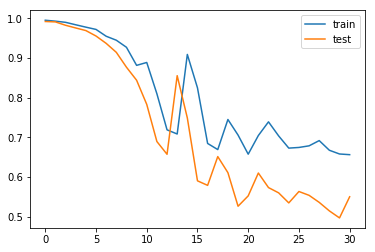

10775.08447265625


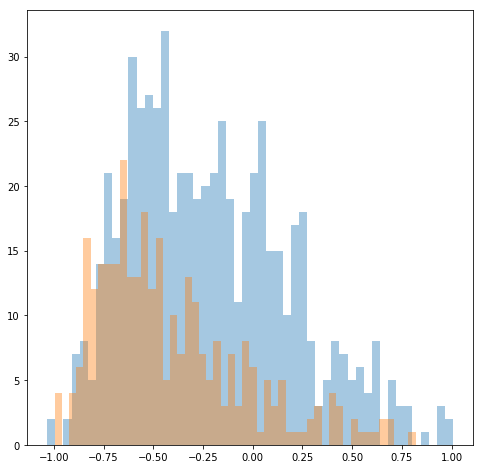

 99%|█████████▉| 99/100 [00:07<00:00, 12.38it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCStorage.cu:58

In [28]:
%%time
losses_train = []
losses_test = []
N = 100
for i in tqdm(range(10000)):
    loss = 0
    for j in tqdm(range(N)):
        k = np.random.choice(len(train_data), p=(probas + 1e-2) / (probas + 1e-2).sum())
        graphx = train_data[k]
        true_labels = graphx.graph['true_labels']

        means, sigmas = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)
        clusters = calc_clusters((means, sigmas), true_labels, device=device)
        l1 = loss_similar((means, sigmas), true_labels, clusters)
        l2 = loss_distinct(clusters)
        ll = l1 + l2
        probas[k] = ll.item()
        loss = loss + ll
        
    losses_train.append(loss.item() / N)
    optimizer_params.zero_grad()
    loss.backward()
    optimizer_params.step()
    
    clear_output()
    
    loss = 0
    for j in tqdm(range(N)):
        k = (i + j) % len(test_data) #np.random.choice(len(train_data), p=probas / probas.sum())
        graphx = test_data[k]
        true_labels = graphx.graph['true_labels']

        means, sigmas = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)
        clusters = calc_clusters((means, sigmas), true_labels, device=device)
        l1 = loss_similar((means, sigmas), true_labels, clusters)
        l2 = loss_distinct(clusters)
        loss = loss + l1 + l2# + loss_m / 100
    losses_test.append(loss.item() / N)
    
    plt.plot(losses_train, label='train');
    plt.plot(losses_test, label='test');
    plt.legend()
    plt.show()

    print((torch.cuda.max_memory_allocated() / 2**20))
    #plot_graphx(graphx)
    plot_clusters(means, true_labels, azim=0, elev=90)
    #plot_clusters(means, true_labels, azim=0, elev=90)
    
    torch.cuda.empty_cache()